In [99]:
import osmnx as ox
import shapely
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.sparse import csr_matrix
import os
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [100]:
def convert_coordinates(eas,nor):
    """
    Convert coordinates from VL95 to WGS84 using swisstopo API. *Check if Geopandas can do this too*

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """
    api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(nor,eas)
    response = requests.get(api_url)
    return(float(response.json()['easting']),float(response.json()['northing']))

def save_numpy_array(np_arr,SAVEFILE_NAME):
    """
    Save numpy array under specified name in '/data/processed' folder

    Parameters
    ----------
    np_arr : numpy.array
                numpy array to save
    SAVEFILE_NAME : string
                name for savefile

    Returns
    -------
    None
    """
    with open('../data/processed/{}.npy'.format(SAVEFILE_NAME), 'wb') as f:
        np.save(f, np_arr)
    return()

def load_numpy_array(SAVEFILE_NAME):
    """
    Load numpy array (with specified name) from '../data/processed' folder

    Parameters
    ----------
    SAVEFILE_NAME : string
                name of savefile to load

    Returns
    -------
    numpy.array
                numpy array (e.g. containing longitudes (float64) and latitudes (float64) in WGS84 coordinates)
    """
    with open('../data/processed/{}.npy'.format(SAVEFILE_NAME), 'rb') as f:
        return(np.load(f)) 

def convert_coordinates_multiple(koord_df,SAVEFILE_NAME):
    """
    Convert multiple coordinates from VL95 to WGS84 using swisstopo API. 
    If a savefile is found, data is loaded from savefile (fast). If no savefile is found data is computed using swisstopo API and is saved afterwards (slow).
    *Check if Geopandas can do this too*

    Parameters
    ----------
    koord_df : pandas.DataFrame
                Dataframe containing longitude and latitude coordinates in VL95 format
    SAVEFILE_NAME : string
                name of savefile to load (if present)

    Returns
    -------
    koord_df_wgs84 : numpy.array
                numpy array containing longitude and latitude coordinates in WGS84 format
    """
    if os.path.exists('../data/processed/{}.npy'.format(SAVEFILE_NAME)):
        print("Savefile found. Loading coordinates from savefile.")
        koord_df_wgs84 = load_numpy_array(SAVEFILE_NAME)

    else:
        koord_df_wgs84 = np.empty(koord_df.shape,dtype='float')
        for i in range(koord_df.shape[0]):

            api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(koord_df[i,1],koord_df[i,0])

            response = requests.get(api_url)
            koord_df_wgs84[i,0] = float(response.json()['easting'])
            koord_df_wgs84[i,1] = float(response.json()['northing'])

            save_numpy_array(koord_df_wgs84,SAVEFILE_NAME)
    return(koord_df_wgs84)

def plot_cluster_shapes(df_adresses,cluster_col):
    """
    Plot adresses on citymap with their according cluster

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """

    import alphashape
    import itertools
    from descartes import PolygonPatch
    #from shapely.geometry import Polygon

    df_adresses = df_adresses[df_adresses[cluster_col].notna()]
    
    cluster_polygon_list = []
    for i,c in enumerate(df_adresses[cluster_col].unique()):
        cluster_adresses = df_adresses.loc[df_adresses[cluster_col]==c,['x','y']].values.tolist()
        cluster_alpha_shape = alphashape.alphashape(cluster_adresses, 120)
        # cluster_path = PolygonPatch(cluster_alpha_shape, alpha=0.2).get_path()
        # cluster_vertices = cluster_path.vertices
        # cluster_polygon = Polygon([(i[0], i[1]) for i in zip(cluster_vertices[:,0],cluster_vertices[:,1])])
        cluster_polygon_list.append(cluster_alpha_shape)

    gdf_cluster = gpd.GeoDataFrame(zip(df_adresses[cluster_col].unique(),cluster_polygon_list),columns=["cluster","geometry"])

    fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
    ax.set_facecolor('xkcd:white')
    colors = itertools.cycle(["tab:blue", "tab:orange", "tab:green","tab:red",'tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan'])
    for i,c in gdf_cluster.iterrows():  
        cluster_color=next(colors)
        cluster_adresses_x = df_adresses.loc[df_adresses[cluster_col]==c['cluster'],'x'].values.tolist()
        cluster_adresses_y = df_adresses.loc[df_adresses[cluster_col]==c['cluster'],'y'].values.tolist()
        ax.scatter(x=cluster_adresses_x, y=cluster_adresses_y, c=cluster_color, marker='.', s=5, zorder=3)
        ax.add_patch(PolygonPatch(c['geometry'], alpha=0.2,color=cluster_color))

    ax.set_title(cluster_col)
    return(fig)

def plot_cluster(df_adresses,cluster_col):
    """
    Plot adresses on citymap with their according cluster

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """

    fig, ax = ox.plot_graph(G, node_size=0, show=False, close=True)
    ax.set_facecolor('xkcd:white')
    ax.scatter(x=df_adresses['x'], y=df_adresses['y'], c=df_adresses[cluster_col], marker='.', s=5, zorder=3)
    ax.set_title(cluster_col)
    return(fig)

def plot_cluster2(df_adresses,cluster_col):
    """
    Plot adresses on citymap with their according cluster

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """
    import itertools
    
    fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False)
    ax.set_facecolor('xkcd:white')
    colors = itertools.cycle(["tab:blue", "tab:orange", "tab:green","tab:red",'tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan'])

    grouped = df_adresses.groupby(cluster_col)
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', color=next(colors), marker='.', s=5, zorder=3)  #colors[key], label=key,

    ax.set_title(cluster_col)
    #ax.get_legend().remove()
    #fig.show()
    return()

## Load street network of zurichs district 9:

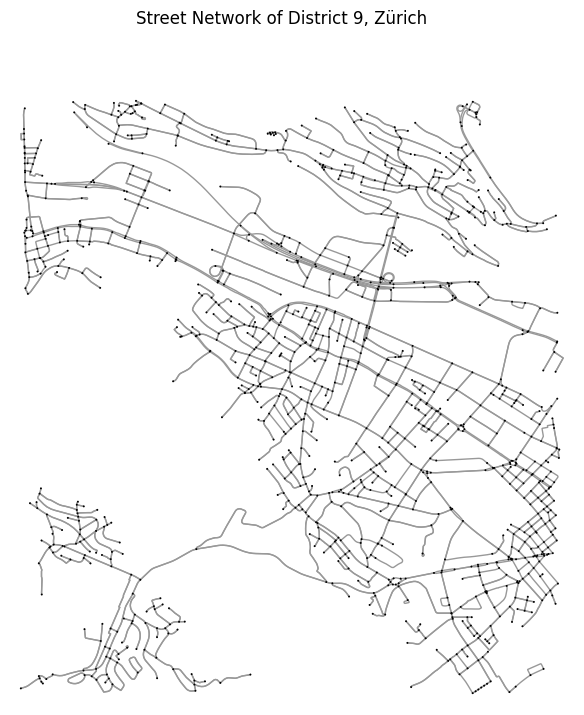

In [101]:
bounding_box_district9 = [47.35834061900655, 47.4096315748066, 8.447603623951219, 8.516244330975884]

G = ox.graph_from_bbox(*bounding_box_district9, network_type='drive') # bike 'drive'
G_projected = ox.project_graph(G)
fig, ax = ox.plot_graph(G_projected,bgcolor='white',node_color='black', node_size=2,show=False,close=True)
fig.suptitle("Street Network of District 9, Zürich")
fig

## Load all addresses located in zurichs district 9:

Savefile found. Loading coordinates from savefile.


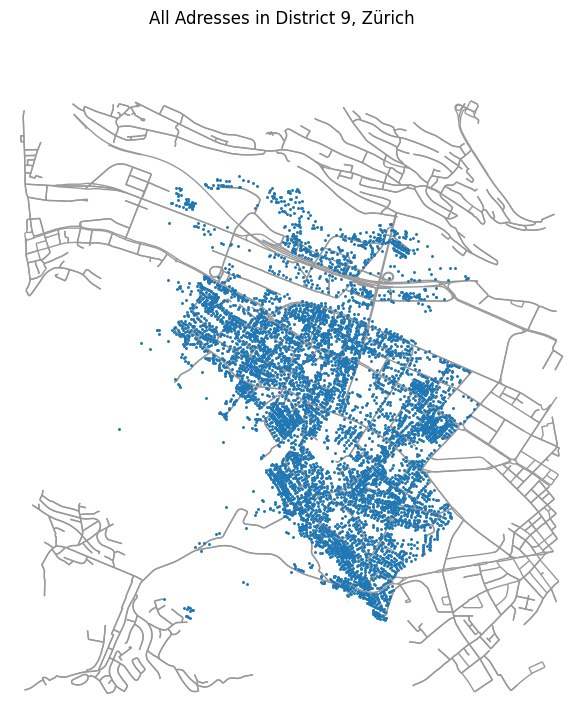

In [102]:
# read dataset 'Adressen'
PATH_ADRESSEN = '../data/raw/geoz.adrstzh_adressen_stzh_p.csv'
df_adressen=pd.read_csv(PATH_ADRESSEN)

# rename coordinates
df_adressen.rename(columns={"hausnummer_koord_ost":"koord_ost","hausnummer_koord_nord":"koord_nord"},inplace=True)

# select addresses from district 9
df_adressen = df_adressen[df_adressen.stadtkreis == 9]

#df_adressen.head()

# convert coordinates from vl95 coordinates to wgs84 coordinates *rename variables here: some are german 'adressen' and some english 'adresses'. Also the prefix 'df' is dropped*
koord_adressen = df_adressen[['koord_nord','koord_ost']].to_numpy()
SAVEFILE_NAME = 'Koordinaten_Adressen_WGS84'
koord_adressen_wgs84 = convert_coordinates_multiple(koord_adressen,SAVEFILE_NAME)
adresses = pd.DataFrame(koord_adressen_wgs84,columns=["x","y"])

# plot adresses together with street network
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=0, show=False, close=True)
ax.set_facecolor('xkcd:white')
ax.scatter(x=adresses['x'], y=adresses['y'], c='tab:blue', marker='.', s=5, zorder=3)
#fig.canvas.draw()
fig.suptitle("All Adresses in District 9, Zürich")
fig

# Try to group adresses into equally sized groups i.e. routes

### V1: Cluster adresses spatially using k-Means (ignore street network, use euclidian distance)

In [5]:
from sklearn.cluster import KMeans

nclusters = 30

kmeans = KMeans(init="random",n_clusters=nclusters,n_init=10,max_iter=300,random_state=42)
#kmeans.fit(np.deg2rad(adresses[['y', 'x']]))
kmeans.fit(adresses[['y', 'x']])
adresses['adress_spatial_cluster_kmeans'] = kmeans.labels_

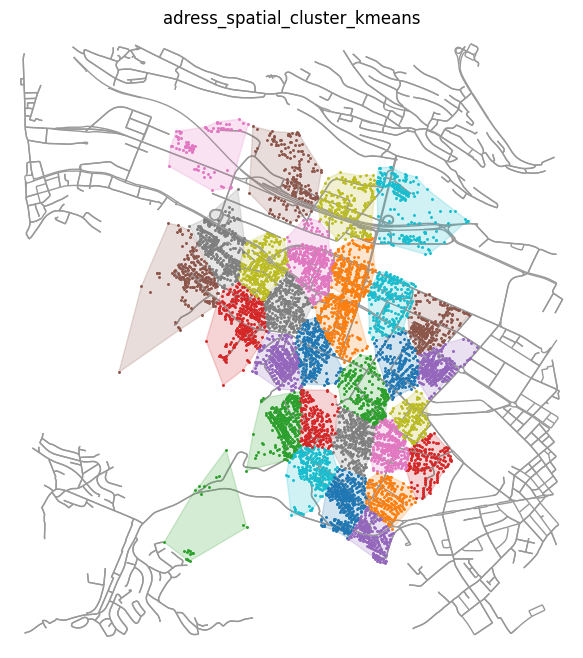

In [42]:
cluster_col = 'adress_spatial_cluster_kmeans'

plot_cluster_shapes(adresses,cluster_col)

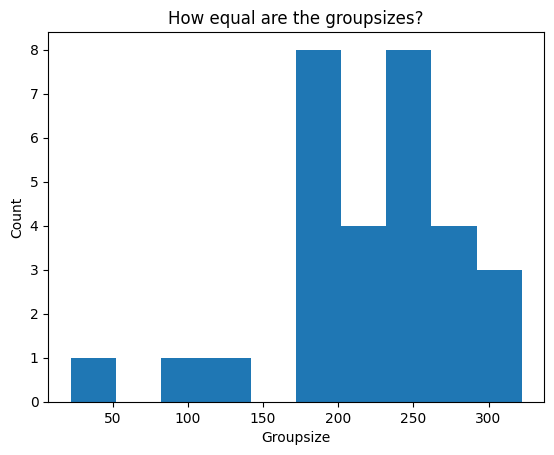

In [ ]:
plt.hist(adresses['adress_spatial_cluster_kmeans'].value_counts(), density=False, bins=10)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

### V2: Cluster adresses along the street network using Spectral Clustering

In [44]:
# For this, we need to create a (network-based) distance matrix first

# attach nearest network node to each adresses
adresses['nn'] = ox.nearest_nodes(G, X=adresses['x'], Y=adresses['y'])
print("Number of addresses:",len(adresses['nn']))

# we'll get distances for each pair of nodes that have adresses attached to them
nodes_unique = pd.Series(adresses['nn'].unique())
nodes_unique.index = nodes_unique.values
print("Number of nodes where adressess are attached to:",len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

Number of addresses: 6575
Number of nodes where adressess are attached to: 451


In [45]:
def network_distance_matrix(u, G, vs=nodes_unique):
    """
    Calculate network-based distance between each node

    Parameters
    ----------
    u : int
                Id of the source node for distance computation
    G : networkx.classes.multidigraph.MultiDiGraph
                MultiDiGraph of the street network
    vs : pandas.Series
                Pandas Series with the Id's of the target nodes for distance computation

    Returns
    -------
    pandas.Series
                Pandas series object containing distance matrix (distances between each of the nodes)
    """
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [48]:
# create (or load) node-based distance matrix called node_dm
if os.path.exists('symmetric_dist_tr_zh.npy'):
    print("Savefile found. Loading coordinates from savefile.")
    ndm = pd.DataFrame(np.load("symmetric_dist_tr_zh.npy"))
    print('Size ndm: ','{:,.0f}'.format(ndm.size),'(',ndm.shape[0],'x',ndm.shape[1],'matrix)')

else:
    node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
    node_dm = node_dm.astype(int)
    print('Size node_dm: ','{:,.0f}'.format(node_dm.size),'(',node_dm.shape[0],'x',node_dm.shape[1],'matrix)')

    # make distance matrix sparse
    # eps=300
    # node_dm[node_dm == 0] = 1
    # node_dm[node_dm > eps] = 0

    # reindex node-based distance matrix to create network-based distance matrix called ndm
    ndm = node_dm.reindex(index=adresses['nn'], columns=adresses['nn'])
    print('Size ndm: ','{:,.0f}'.format(ndm.size),'(',ndm.shape[0],'x',ndm.shape[1],'matrix)')
    with open('symmetric_dist_tr_zh.npy', 'wb') as f:
        np.save(f, ndm.to_numpy().astype('float32'))

# # convert network-based distance matrix to a sparse matrix
# ndm_sparse = csr_matrix(ndm)

Savefile found. Loading coordinates from savefile.
Size ndm:  43,230,625 ( 6575 x 6575 matrix)


In [49]:
from sklearn.cluster import SpectralClustering
#from sklearn.cluster import AffinityPropagation

# parameterize
nclusters = 30
nneighbors = 500

print('For nneighbors pick a value between {:,.0f} and {:,.0f}. Value chosen: {}'.format(6575*0.07,6575*0.15,nneighbors))

# use metric=precomputed to fit model to the sparse network-based distance matrix
db = SpectralClustering(n_clusters=nclusters,assign_labels='discretize',n_neighbors=nneighbors,affinity="precomputed_nearest_neighbors",random_state=0)

db.fit(ndm.to_numpy().astype('float32'))

adresses['adress_network_cluster_spectral'] = db.labels_

For nneighbors pick a value between 460 and 986. Value chosen: 500


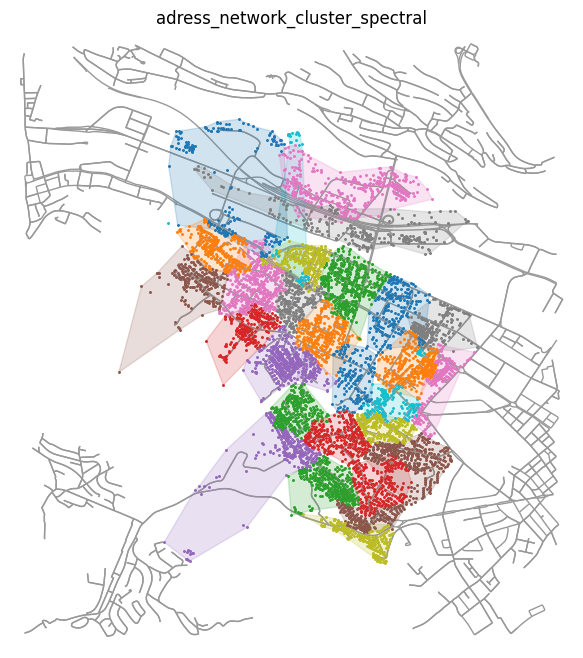

In [50]:
cluster_col = 'adress_network_cluster_spectral'

plot_cluster_shapes(adresses,cluster_col)

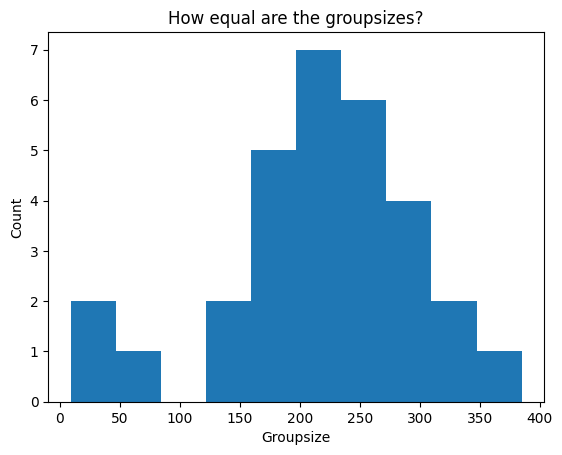

In [257]:
plt.hist(adresses['adress_network_cluster_spectral'].value_counts(), density=False, bins=10)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

### V3: Cluster adresses along the street network using 'SpectralEqualSizeClustering'

In [53]:
import sys
sys.path.insert(0, '/Users/Derk/Documents/GitHub/Equal-Size-Spectral-Clustering/source_code')
from spectral_equal_size_clustering import SpectralEqualSizeClustering

cl = SpectralEqualSizeClustering(nclusters=nclusters, nneighbors=500, equity_fraction=1, seed=11362)
cluster_labels = cl.fit(ndm.to_numpy().astype('float32'))
adresses['adress_network_cluster_spectralEq'] = cluster_labels

INFO:root:parameters of the cluster: nclusters: (30,) equity_fr: 1 nneighbours: 500
INFO:root:ideal elements per cluster: [220, 220, 220, 220, 220, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219]
INFO:root:min-max range of elements: 219-220


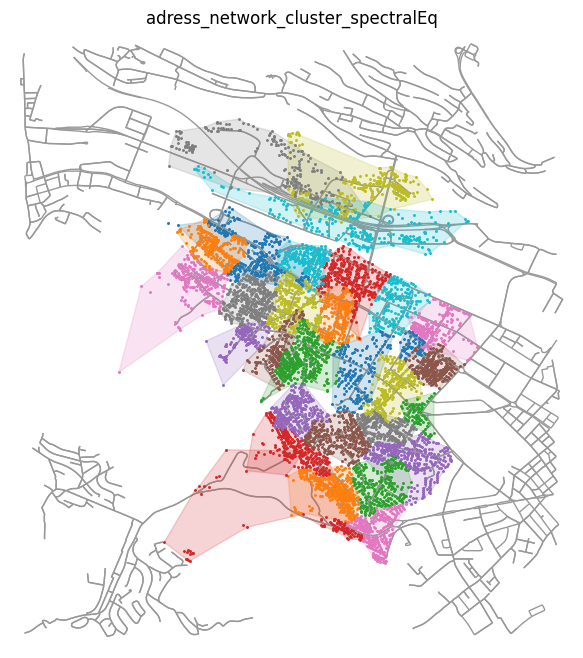

In [54]:
cluster_col = 'adress_network_cluster_spectralEq'

plot_cluster_shapes(adresses,cluster_col)

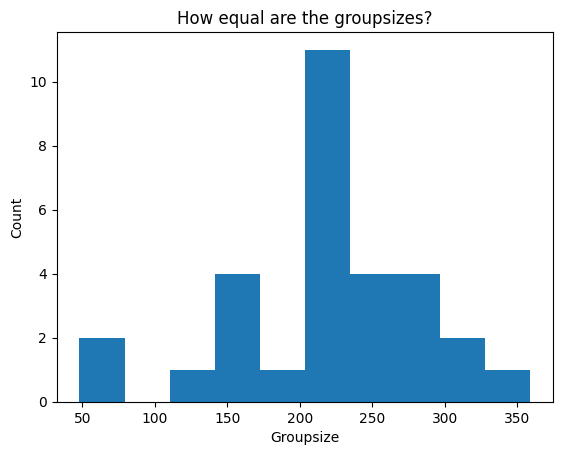

In [262]:
plt.hist(adresses['adress_network_cluster_spectralEq'].value_counts(), density=False, bins=10)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

#### Save

In [ ]:
# save the graph to disk
ox.save_graph_geopackage(G, filepath='data/graph.gpkg')

In [ ]:
# save and show the clustered adresses data set
adresses = adresses.reindex(columns=['x', 'y', 'nn', 'spatial_cluster', 'network_cluster'])
adresses.to_csv('data/clustered.csv', encoding='utf-8', index=False)

### V4: Cluster city blocks spatially using k-Means

In [112]:
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from skimage.measure import label, find_contours, points_in_poly
from skimage.color import label2rgb

#ox.config(log_console=True, use_cache=True)

def k_core(G, k):
    """
    Convert coordinates from VL95 to WGS84 using swisstopo API. *Check if Geopandas can do this too*

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """
    H = nx.Graph(G, as_view=True)
    H.remove_edges_from(nx.selfloop_edges(H))
    core_nodes = nx.k_core(H, k)
    H = H.subgraph(core_nodes)
    return G.subgraph(core_nodes)


def plot2img(fig):
    """
    Convert coordinates from VL95 to WGS84 using swisstopo API. *Check if Geopandas can do this too*

    Parameters
    ----------
    eas : float64
                longitude in VL95 coordinates
    nor : float64
                latitude in VL95 coordinates

    Returns
    -------
    tuple
                A tuple containing longitude (float64) and latitude (float64) in WGS84 coordinates
    """
    # remove margins
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # convert to image
    # https://stackoverflow.com/a/35362787/2912349
    # https://stackoverflow.com/a/54334430/2912349
    canvas = FigureCanvas(fig)
    canvas.draw()
    img_as_string, (width, height) = canvas.print_to_buffer()
    as_rgba = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))
    return as_rgba[:,:,:3]

In [113]:
G2a = ox.graph_from_bbox(47.35834061900655, 47.4096315748066, 8.447603623951219, 8.516244330975884, network_type='bike') # 'walk' 'drive' 'bike
G2b = ox.graph_from_bbox(47.35834061900655, 47.4096315748066, 8.447603623951219, 8.516244330975884, custom_filter='["railway"]') #network_type='bike',custom_filter='["railway"]')
G2 = nx.compose(G2a, G2b)

nodelist = list(G2.nodes(data=True))
nodelist = list(zip([n[1]['x'] for n in nodelist],[n[1]['y'] for n in nodelist]))

In [114]:
import alphashape
from descartes import PolygonPatch

alpha_shape = alphashape.alphashape(nodelist, 40)
xx, yy = alpha_shape.exterior.coords.xy
hull_list = list(zip(xx.tolist(),yy.tolist()))

# find node names for hull points
nodelist = list(G2.nodes(data=True))
nodes_list = list(zip([n[0] for n in nodelist],[n[1]['x'] for n in nodelist],[n[1]['y'] for n in nodelist]))
hull_names_list = []

for h in hull_list:
    x = h[0]
    y = h[1]
    answer = [cood for cood in nodes_list if (cood[1]) == x and (cood[2]) == y]
    hull_names_list.append(answer[0][0])

# add edges where hull lines go through
for i in range(len(hull_names_list)-1):
    G2.add_edge(hull_names_list[i], hull_names_list[i+1], length = 2)

# fig, ax = plt.subplots()
# ax.scatter(*zip(*nodelist))
# ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))

In [115]:
H = k_core(G2, 2)
fig1, ax1 = ox.plot_graph(H, node_size=0, edge_color='k', edge_linewidth=1, bgcolor='white', figsize=(10,10), dpi=300,show=False,close=True)
ax1.axis('equal')

"""
/var/folders/mc/m_k2wlrx30725ghkjs75z2700000gn/T/ipykernel_12709/1797651153.py:62: 
DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  as_rgba = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))
"""
img = plot2img(fig1)
label_image = label(img > 140)
image_label_overlay = label2rgb(label_image[:,:,0], image=img[:,:,0])
#fig2, ax2 = plt.subplots(1,1)
#ax2.axis('equal')
#ax2.imshow(image_label_overlay)
#ax.imshow(label_image)

/var/folders/mc/m_k2wlrx30725ghkjs75z2700000gn/T/ipykernel_15370/1797651153.py:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  as_rgba = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))


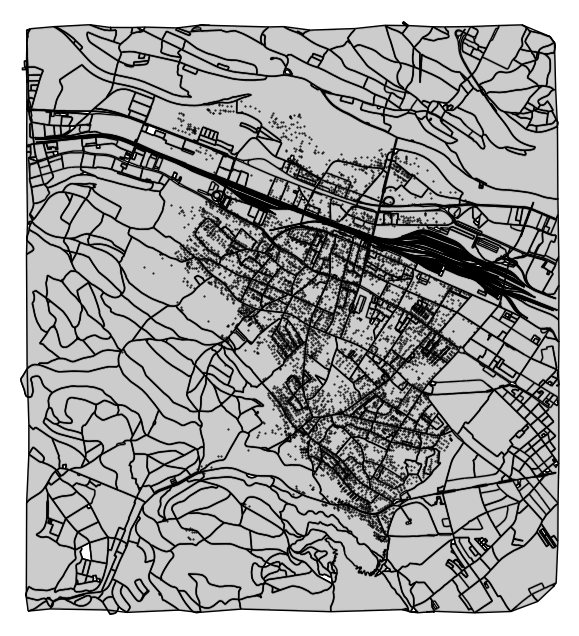

In [387]:
max_pixel_cityblock = 53300
min_pixel_cityblock = 10

fig4, ax4 = ox.plot_graph(H, node_size=0, edge_color='k', edge_linewidth=1, bgcolor='white', show=False)

pixel_per_cityblock = []

for ii in np.unique(label_image.ravel()):
    mask = (label_image[:,:,0] == ii)
    pixel_per_cityblock.append(mask.sum())

cityblock_id = np.unique(label_image.ravel())[(np.array(pixel_per_cityblock)<53300) & (np.array(pixel_per_cityblock)>20)]
cityblock_patch = []

for ii in cityblock_id:
    mask = (label_image[:,:,0] == ii)
    contours = find_contours(mask.astype(float), 0.5)

    # select the largest contiguous contour
    contour = sorted(contours, key=lambda x: len(x))[-1]

    # display the image and plot the contour
    # this allows us to transform the contour coordinates back to the original data cordinates
    fig3, ax3 = plt.subplots()
    ax3.imshow(mask, interpolation='nearest', cmap='gray')
    ax3.autoscale(enable=False)
    ax3.step(contour.T[1], contour.T[0], linewidth=2, c='r')
    plt.close(fig3)

    # first column indexes rows in images, second column indexes columns
    # therefor we need to swap contour array to get xy values
    contour = np.fliplr(contour)

    pixel_to_data = ax3.transData + ax3.transAxes.inverted() + ax1.transAxes + ax1.transData.inverted()
    transformed_contour = pixel_to_data.transform(contour)
    transformed_contour_path = Path(transformed_contour, closed=True)
    patch = PathPatch(transformed_contour_path, facecolor='black',alpha=0.2)
    cityblock_patch.append(patch.get_path())
    
    ax4.add_patch(patch)

ax4.scatter(x=adresses['x'], y=adresses['y'], marker='.', s=1, zorder=3, color='black');

In [143]:
from shapely.geometry import Point

adresses_list = list(zip(adresses['x'].tolist(),adresses['y'].tolist()))
cityblock_size = []
cityblock_adresses = []
cityblock_adressId = []

for block in cityblock_patch:
    contains_adress = []
    cityblock_adresses_temp = []
    cityblock_adressId_temp = []

    for i,a in enumerate(adresses_list):
        bool_contains_adress = block.contains_point(a)
        contains_adress.append(bool_contains_adress)
        if bool_contains_adress:
            cityblock_adresses_temp.append(a)
            cityblock_adressId_temp.append(i)

    cityblock_size.append(sum(contains_adress))
    cityblock_adresses.append(cityblock_adresses_temp)
    cityblock_adressId.append(cityblock_adressId_temp)

In [188]:
## insert in previous loop or try to avoid loop here (apply to list)
from sklearn.metrics.pairwise import pairwise_distances

cityblock_centers_x = []
cityblock_centers_y = []
for a in cityblock_adresses:
    if len(a) > 0:
        # cityblock_centers_x.append(np.mean([a_[0] for a_ in a]))
        # cityblock_centers_y.append(np.mean([a_[1] for a_ in a]))
        distMatrix = pairwise_distances(a)
        medoid = a[np.argmin(distMatrix.sum(axis=0))]
        cityblock_centers_x.append(medoid[0])
        cityblock_centers_y.append(medoid[1])
    else:
        cityblock_centers_x.append(0.)
        cityblock_centers_y.append(0.)

pdf_cityblocks = pd.DataFrame(zip(cityblock_centers_x,cityblock_centers_y,cityblock_size,cityblock_adresses,cityblock_adressId,cityblock_patch),columns=['x','y','blocksize','addr','ids','patch'])
pdf_cityblocks = pdf_cityblocks[pdf_cityblocks.blocksize>0].reset_index()

In [189]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="random",n_clusters=30,n_init=10,max_iter=1000,random_state=42)

#kmeans.fit(np.deg2rad(adresses[['y', 'x']]))
kmeans.fit(pdf_cityblocks[['x','y']],sample_weight=pdf_cityblocks['blocksize']) #

pdf_cityblocks['cityblock_cluster'] = kmeans.labels_

In [190]:
adresses['cityblock_spacial_cluster_kmeans'] = np.nan

for i,id in enumerate(pdf_cityblocks['ids']):
    adresses.loc[id,'cityblock_spacial_cluster_kmeans'] = str(pdf_cityblocks.loc[i,'cityblock_cluster'])
    #print()

adresses_ = adresses[~adresses.cityblock_spacial_cluster_kmeans.isna()].reset_index(drop=True)

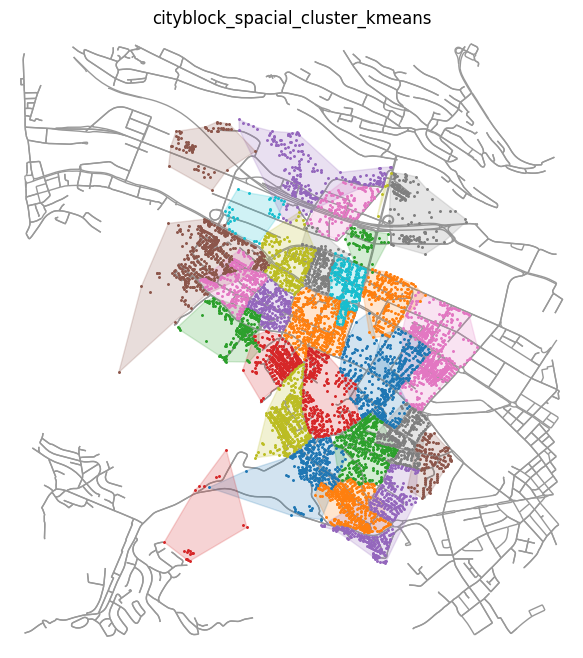

In [191]:
adresses_ = adresses_[adresses_.cityblock_spacial_cluster_kmeans != "10"]
cluster_col = 'cityblock_spacial_cluster_kmeans'

plot_cluster_shapes(adresses_,cluster_col)

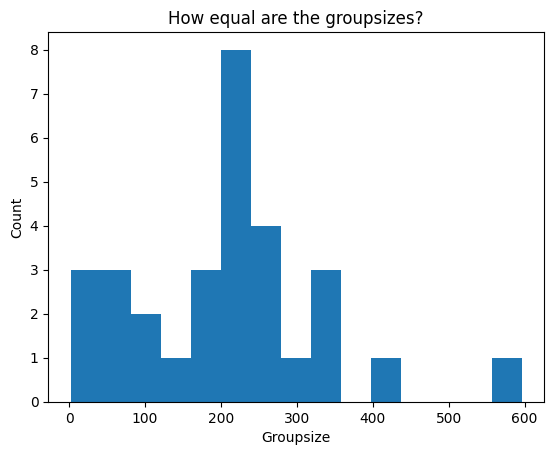

In [303]:
plt.hist(adresses['cityblock_spacial_cluster_kmeans'].value_counts(), density=False, bins=15)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

### V5: Cluster city blocks along the street network using k-Means

In [192]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

# Attach nearest node to each cityblock then make network-based distance matrix

# attach nearest network node to each cityblock
pdf_cityblocks['nn'] = ox.nearest_nodes(G, X=pdf_cityblocks['x'], Y=pdf_cityblocks['y'])
print("Number of cityblocks:",len(pdf_cityblocks['nn']))

# we'll get distances for each pair of nodes that have adresses attached to them
nodes_unique = pd.Series(pdf_cityblocks['nn'].unique())
nodes_unique.index = nodes_unique.values
print("Number of nodes where cityblocks are attached to:",len(nodes_unique))

# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

Number of cityblocks: 250
Number of nodes where cityblocks are attached to: 189


In [193]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

def network_distance_matrix(u, G, vs=nodes_unique):
    """
    Calculate network-based distance between each node

    Parameters
    ----------
    u : int
                Id of the source node for distance computation
    G : networkx.classes.multidigraph.MultiDiGraph
                MultiDiGraph of the street network
    vs : pandas.Series
                Pandas Series with the Id's of the target nodes for distance computation

    Returns
    -------
    pandas.Series
                Pandas series object containing distance matrix (distances between each of the nodes)
    """
    dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in vs]
    return pd.Series(dists, index=vs)

In [194]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
#node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm_s)
node_dm = node_dm.astype(int)
print('Size node_dm: ','{:,.0f}'.format(node_dm.size),'(',node_dm.shape[0],'x',node_dm.shape[1],'matrix)')

# reindex node-based distance matrix to create network-based distance matrix called ndm
ndm = node_dm.reindex(index=pdf_cityblocks['nn'], columns=pdf_cityblocks['nn'])
print('Size ndm: ','{:,.0f}'.format(ndm.size),'(',ndm.shape[0],'x',ndm.shape[1],'matrix)')

Size node_dm:  35,721 ( 189 x 189 matrix)
Size ndm:  62,500 ( 250 x 250 matrix)


In [247]:
from sklearn.cluster import SpectralClustering
#from sklearn.cluster import AffinityPropagation

# parameterize
nclusters = 30
nneighbors = 10

print('For nneighbors pick a value between {:,.0f} and {:,.0f}. Value chosen: {}'.format(250*0.07,250*0.15,nneighbors))

# use metric=precomputed to fit model to the sparse network-based distance matrix
db = SpectralClustering(n_clusters=nclusters,assign_labels='discretize',n_neighbors=nneighbors,affinity="precomputed_nearest_neighbors",random_state=0)

db.fit(ndm.to_numpy().astype('float32'))

pdf_cityblocks['cityblock_network_cluster_spectral'] = db.labels_

For nneighbors pick a value between 18 and 38. Value chosen: 10


In [248]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

# harmonize name in pdf_cityblocks: 'cityblock_network_cluster_dbscan'

adresses['cityblock_network_cluster_spectral'] = np.nan

for i,id in enumerate(pdf_cityblocks['ids']):
    adresses.loc[id,'cityblock_network_cluster_spectral'] = str(pdf_cityblocks.loc[i,'cityblock_network_cluster_spectral'])
    #print()

adresses_ = adresses[~adresses.cityblock_network_cluster_spectral.isna()].reset_index(drop=True)

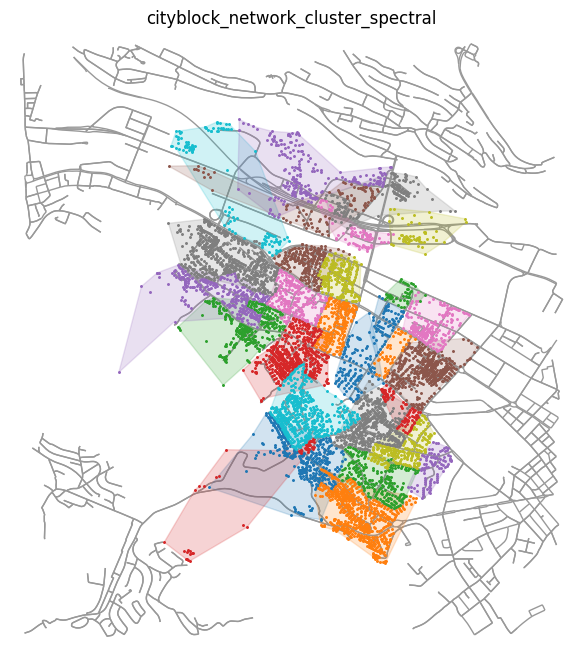

In [249]:
adresses_ = adresses_[adresses_.cityblock_network_cluster_spectral != "10"]
cluster_col = 'cityblock_network_cluster_spectral'

plot_cluster_shapes(adresses_,cluster_col)

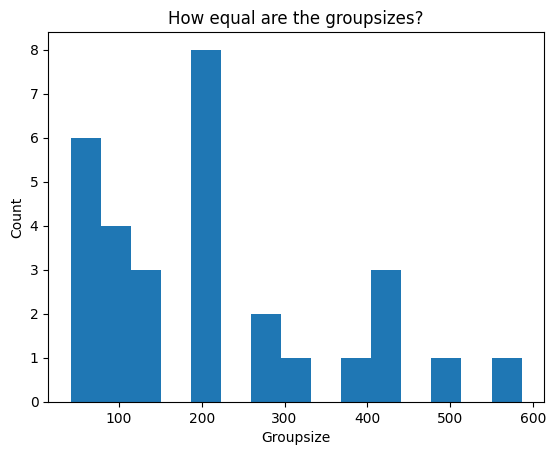

In [250]:
plt.hist(adresses['cityblock_network_cluster_spectral'].value_counts(), density=False, bins=15)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

### V6: Cluster city blocks along neighborhood graph using SKATER

In [272]:
cityblock_geo = []
import shapely
from shapely.geometry import Polygon
#for i in range(len(cs.collections)):
for i,p in enumerate(pdf_cityblocks.patch):
    #p = cs.collections[i].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    poly = Polygon([(i[0], i[1]) for i in zip(x,y)])
    cityblock_geo.append(poly)

pdf_cityblocks['geometry'] = cityblock_geo
gdf_cityblocks = gpd.GeoDataFrame(pdf_cityblocks)

#### A) Create libpysal.weights object from scratch

In [362]:
geos_buffered = []
for i,geo in enumerate(gdf_cityblocks.geometry):
    geos_buffered.append(geo.buffer(0.0001))
pdf_cityblocks_buffered = pd.DataFrame(zip(list(range(len(geos_buffered))),geos_buffered),columns=["index","geometry"])
gdf_cityblocks_buffered = gpd.GeoDataFrame(pdf_cityblocks_buffered.reset_index(drop=True).reset_index())
#gdf_cityblocks_buffered.plot();

In [293]:
 def find_cityblock_neighbors(x,gdf_cityblocks_buffered=gdf_cityblocks_buffered):
    neighbors_list = gdf_cityblocks_buffered[gdf_cityblocks_buffered.overlaps(x)]['index'].tolist()
    return(neighbors_list)

gdf_cityblocks['cityblock_neighbors'] = gdf_cityblocks_buffered['geometry'].apply(find_cityblock_neighbors)

In [309]:
from shapely.ops import nearest_points

def find_nearest_point(x):
    unary_union = gdf_cityblocks.drop(gdf_cityblocks.iloc[[x]].index).unary_union
    np = nearest_points(gdf_cityblocks.iloc[x]['centroid'],unary_union)[1]
    return(np)

gdf_cityblocks['centroid'] = gdf_cityblocks.centroid
gdf_nearest_points = gpd.GeoDataFrame(zip(gdf_cityblocks.index.map(find_nearest_point),gdf_cityblocks.index),columns=['geometry','iid'])

gdf_cityblocks['nearest_neighbor'] = gdf_nearest_points.sjoin_nearest(gdf_cityblocks).sort_values('iid')['index_right']

In [310]:
gdf_cityblocks['neighbor'] = gdf_cityblocks.apply(lambda x: x.cityblock_neighbors if len(x.cityblock_neighbors)>0 else [x.nearest_neighbor],axis=1)

In [311]:
w = W(dict(zip(gdf_cityblocks.index.tolist(),gdf_cityblocks['neighbor'].tolist())))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


#### B) Create libpysal.weights object using Queen, Rook, KNN (shapes have to be modified for this)

In [363]:
geos_buffered = []
for i,geo in enumerate(gdf_cityblocks.geometry):
    geos_buffered.append(geo.buffer(0.0002))
pdf_cityblocks_buffered = pd.DataFrame(zip(list(range(len(geos_buffered))),geos_buffered),columns=["index","geometry"])
gdf_cityblocks_buffered = gpd.GeoDataFrame(pdf_cityblocks_buffered.reset_index(drop=True).reset_index())
#gdf_cityblocks_buffered.plot();

<Axes: >

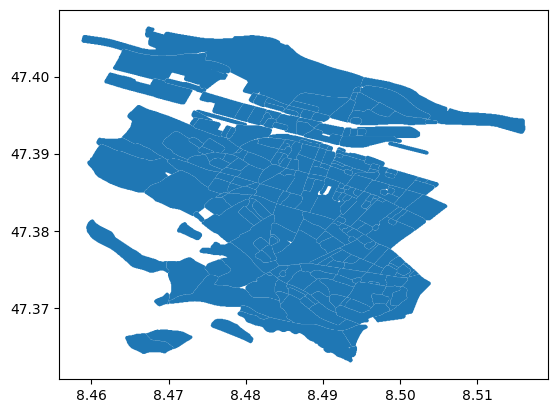

In [322]:
 def crop_cityblock_using_neighbors(i):
    unary_union = gdf_cityblocks_buffered.drop(i).unary_union
    cropped_cityblock = gdf_cityblocks_buffered.loc[i,'geometry'].difference(unary_union)
    gdf_cityblocks_buffered.loc[i,'geometry'] = cropped_cityblock
    return()

#gdf_cityblocks_buffered['cityblock_neighbors'] = 
gdf_cityblocks_buffered.index.map(crop_cityblock_using_neighbors);
gdf_cityblocks_buffered.plot()


# gdf_cityblocks['coords'] = gdf_cityblocks['geometry'].apply(lambda x: x.representative_point().coords[:])
# gdf_cityblocks['coords'] = [coords[0] for coords in gdf_cityblocks['coords']]


# gdf_cityblocks.plot(figsize=[10,10])
# for idx, row in gdf_cityblocks.iterrows():
#     plt.annotate(text=row['index'], xy=row['coords'],
#                  horizontalalignment='center')

In [350]:
from libpysal.weights import Queen, Rook, KNN

w = Queen.from_dataframe(gdf_cityblocks_buffered) #,k=3

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 3 islands with ids: 59, 170, 246.
  warnings.warn(message)


In [351]:
gdf_cityblocks['index'] = gdf_cityblocks.index

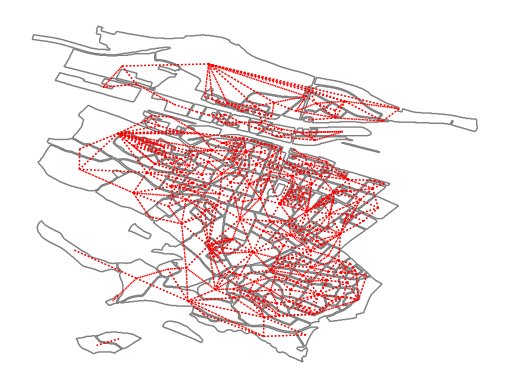

In [352]:
ax = gdf_cityblocks.plot(edgecolor='grey', facecolor='w')
f,ax = w.plot(gdf_cityblocks, ax=ax, indexed_on="index", edge_kws=dict(color='r', linestyle=':', linewidth=1), node_kws=dict(marker=''))
ax.set_axis_off()

In [353]:
n_clusters = 30
floor = 1
trace = False
islands = "increase"
attrs_name = ["blocksize"]

In [354]:
from sklearn.metrics import pairwise as skm

spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=np.sum,
    center=np.mean,
    verbose=2
)

In [355]:
import spopt

model = spopt.region.Skater(
    gdf_cityblocks,
    w,
    attrs_name,
    n_clusters=n_clusters,
    floor=floor,
    trace=trace,
    islands=islands,
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spopt/region/skater.py:537: OptimizeWarning: By default, the graph is disconnected! Increasing `n_clusters` from 30 to 36 in order to account for islands.
  model.fit(


Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...: 100%|██████████| 244/244 [00:00<00:00, 332.48it/s]


making cut deletion(in_node=152, out_node=136, score=4906.4097560975615)...


finding cut...: 100%|██████████| 243/243 [00:01<00:00, 193.28it/s]


making cut deletion(in_node=79, out_node=48, score=4632.049150036955)...


finding cut...: 100%|██████████| 242/242 [00:00<00:00, 331.67it/s]


making cut deletion(in_node=155, out_node=178, score=4376.824041811847)...


finding cut...: 100%|██████████| 241/241 [00:00<00:00, 268.85it/s]


making cut deletion(in_node=245, out_node=237, score=4164.571294559099)...


finding cut...: 100%|██████████| 240/240 [00:00<00:00, 278.87it/s]


making cut deletion(in_node=1, out_node=0, score=3962.4615384615386)...


finding cut...: 100%|██████████| 239/239 [00:01<00:00, 212.68it/s]


making cut deletion(in_node=153, out_node=149, score=3811.2804232804233)...


finding cut...: 100%|██████████| 238/238 [00:00<00:00, 259.90it/s]


making cut deletion(in_node=227, out_node=216, score=3687.765765765766)...


finding cut...: 100%|██████████| 237/237 [00:00<00:00, 242.12it/s]


making cut deletion(in_node=75, out_node=94, score=3566.3851331577407)...


finding cut...: 100%|██████████| 236/236 [00:01<00:00, 229.53it/s]


making cut deletion(in_node=23, out_node=40, score=3433.1668325041464)...


finding cut...: 100%|██████████| 235/235 [00:01<00:00, 220.98it/s]


making cut deletion(in_node=19, out_node=48, score=3320.1668325041464)...


finding cut...: 100%|██████████| 234/234 [00:01<00:00, 209.18it/s]


making cut deletion(in_node=172, out_node=184, score=3218.824737945493)...


finding cut...: 100%|██████████| 233/233 [00:01<00:00, 191.28it/s]


making cut deletion(in_node=109, out_node=134, score=3122.5136268343813)...


finding cut...: 100%|██████████| 232/232 [00:01<00:00, 186.29it/s]


making cut deletion(in_node=171, out_node=185, score=2993.3443960651502)...


finding cut...: 100%|██████████| 231/231 [00:01<00:00, 176.81it/s]


making cut deletion(in_node=104, out_node=86, score=2872.1136268343816)...


finding cut...: 100%|██████████| 230/230 [00:01<00:00, 171.80it/s]


making cut deletion(in_node=178, out_node=162, score=2783.113626834381)...


finding cut...: 100%|██████████| 229/229 [00:01<00:00, 164.65it/s]


making cut deletion(in_node=97, out_node=95, score=2694.429182389937)...


finding cut...: 100%|██████████| 228/228 [00:01<00:00, 155.23it/s]


making cut deletion(in_node=151, out_node=160, score=2621.8958490566033)...


finding cut...: 100%|██████████| 227/227 [00:01<00:00, 152.65it/s]


making cut deletion(in_node=198, out_node=219, score=2555.8742857142856)...


finding cut...: 100%|██████████| 226/226 [00:01<00:00, 148.40it/s]


making cut deletion(in_node=207, out_node=192, score=2478.376216216216)...


finding cut...: 100%|██████████| 225/225 [00:01<00:00, 142.15it/s]


making cut deletion(in_node=2, out_node=1, score=2413.9531392931394)...


finding cut...: 100%|██████████| 224/224 [00:01<00:00, 136.07it/s]


making cut deletion(in_node=11, out_node=5, score=2359.297268847795)...


finding cut...: 100%|██████████| 223/223 [00:01<00:00, 132.76it/s]


making cut deletion(in_node=205, out_node=203, score=2305.4288787185355)...


finding cut...: 100%|██████████| 222/222 [00:01<00:00, 128.94it/s]


making cut deletion(in_node=191, out_node=193, score=2233.4288787185355)...


finding cut...: 100%|██████████| 221/221 [00:01<00:00, 125.42it/s]


making cut deletion(in_node=226, out_node=216, score=2183.4288787185355)...


finding cut...: 100%|██████████| 220/220 [00:01<00:00, 121.05it/s]


making cut deletion(in_node=107, out_node=116, score=2135.932375222032)...


finding cut...: 100%|██████████| 219/219 [00:01<00:00, 118.67it/s]


making cut deletion(in_node=70, out_node=81, score=2092.5507536004106)...


finding cut...: 100%|██████████| 218/218 [00:02<00:00, 97.54it/s] 


making cut deletion(in_node=123, out_node=97, score=2053.5057085553653)...


finding cut...: 100%|██████████| 217/217 [00:02<00:00, 100.84it/s]


making cut deletion(in_node=150, out_node=136, score=2015.8390418886986)...


finding cut...: 100%|██████████| 216/216 [00:02<00:00, 90.41it/s]


making cut deletion(in_node=151, out_node=156, score=1979.372375222032)...


finding cut...: 100%|██████████| 215/215 [00:02<00:00, 100.77it/s]

making cut deletion(in_node=50, out_node=42, score=1943.059430698561)...
  (2, 4)	11.0
  (3, 5)	23.0
  (4, 7)	3.0
  (5, 26)	14.0
  (6, 5)	23.0
  (6, 8)	1.0
  (9, 12)	9.0
  (10, 8)	44.0
  (12, 17)	12.0
  (13, 12)	5.0
  (13, 15)	7.0
  (15, 10)	33.0
  (15, 20)	4.0
  (15, 29)	1.0
  (16, 26)	9.0
  (18, 7)	9.0
  (20, 22)	7.0
  (21, 18)	6.0
  (24, 21)	4.0
  (24, 35)	1.0
  (25, 15)	2.0
  (26, 14)	8.0
  (26, 32)	9.0
  (27, 23)	3.0
  (27, 31)	4.0
  :	:
  (216, 210)	4.0
  (218, 221)	1.0
  (219, 232)	4.0
  (219, 245)	111.0
  (220, 222)	24.0
  (221, 209)	9.0
  (224, 220)	2.0
  (225, 212)	10.0
  (227, 241)	25.0
  (229, 230)	3.0
  (229, 236)	7.0
  (230, 218)	6.0
  (231, 225)	1.0
  (231, 235)	1.0
  (231, 239)	3.0
  (232, 231)	11.0
  (233, 223)	3.0
  (235, 228)	9.0
  (238, 224)	11.0
  (240, 238)	9.0
  (243, 227)	2.0
  (243, 242)	3.0
  (244, 219)	15.0
  (245, 247)	94.0
  (249, 248)	8.0
added minimum_spanning_forest_ :)


In [356]:
gdf_cityblocks["cityblock_neigbor_cluster_skater"] = model.labels_

In [357]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

# harmonize name in pdf_cityblocks: 'cityblock_network_cluster_dbscan'

adresses['cityblock_neigbor_cluster_skater'] = np.nan

for i,id in enumerate(gdf_cityblocks['ids']):
    adresses.loc[id,'cityblock_neigbor_cluster_skater'] = str(gdf_cityblocks.loc[i,'cityblock_neigbor_cluster_skater'])
    #print()

adresses_ = adresses[~adresses.cityblock_neigbor_cluster_skater.isna()].reset_index(drop=True)

In [360]:
#adresses_.groupby('cityblock_neigbor_cluster_skater').agg('count')

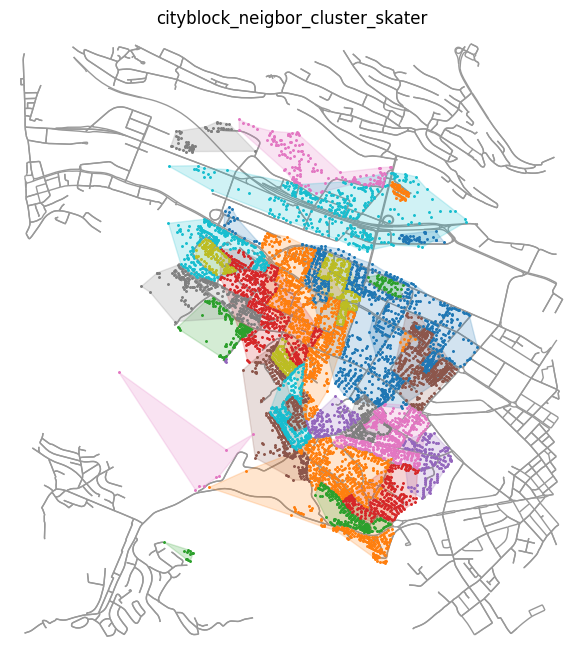

In [359]:
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_skater != "13"]
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_skater != "24"]
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_skater != "34"]
cluster_col = 'cityblock_neigbor_cluster_skater'

plot_cluster_shapes(adresses_,cluster_col)

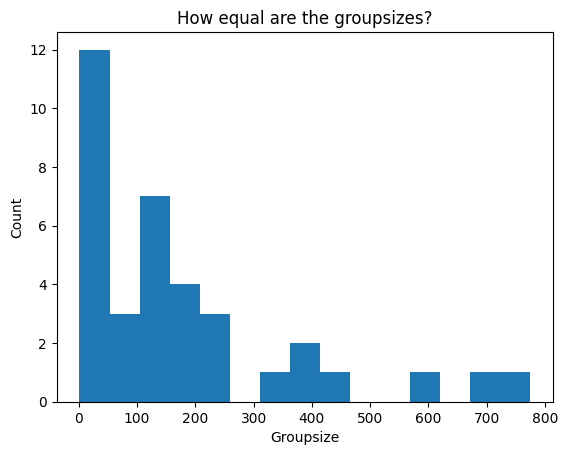

In [361]:
plt.hist(adresses['cityblock_neigbor_cluster_skater'].value_counts(), density=False, bins=15)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

### V7: Cluster city blocks along neighborhood graph using a homemade algorithm: 'Peripheral Aggregation' (PAA)

In [375]:
import random

seed_nneighbors = 1
target_clustersize = gdf_cityblocks.blocksize.sum()/n_clusters
gdf_cityblocks["label"] = gdf_cityblocks["index"]
gdf_cityblocks["Final"] = False
bool_iterate = True

while bool_iterate:

    iterate_over = gdf_cityblocks[gdf_cityblocks.loc[:,'Final'] != True].label.unique()
    random.shuffle(iterate_over)
    ncluster_begin = len(gdf_cityblocks.label.unique())
    print("Starting with",ncluster_begin,"clusters")
    cluster_gone = []

    for i,l in enumerate(iterate_over):
        
        if l not in cluster_gone:
            n = []
            for ind_ in gdf_cityblocks.loc[gdf_cityblocks.label == l,'index'].tolist():
                neigh_ind = w.neighbors[ind_]
                neigh_label = gdf_cityblocks[gdf_cityblocks.loc[:,'Final'] != True].loc[gdf_cityblocks["index"].isin(neigh_ind),'label'].tolist()
                for lab_ in neigh_label:
                    if (lab_ not in cluster_gone) & (lab_ != l): # drop cluster_gone here? backup: if not (lab_ in cluster_gone or lab_ != l)
                        n.append(lab_)
            n = list(set(n))

            if len(n) == seed_nneighbors:
                print("Found cluster with only",seed_nneighbors,"neghbors. l=",l,"n=",n)
                current_clustersize = gdf_cityblocks[["label","blocksize"]].groupby("label").sum('blocksize').loc[l,"blocksize"]
                if current_clustersize > 0.95*target_clustersize:
                    gdf_cityblocks.loc[gdf_cityblocks.label == l,'Final'] = True
                
                affinities_list = []
                if len(n)>1:
                    for n_ in n:
                        #n_ = n[0]

                        # remove isin! no ned to pass list here
                        n_=[n_]

                        gdf_thiscluster_temp = gdf_cityblocks_buffered[gdf_cityblocks_buffered['index'].isin(gdf_cityblocks.loc[gdf_cityblocks.label ==l,'index'].tolist())]
                        q = gdf_thiscluster_temp.geometry.tolist()
                        q = gpd.GeoSeries(shapely.ops.unary_union(q))

                        gdf_neighborcluster_n_temp = gdf_cityblocks_buffered[gdf_cityblocks_buffered['index'].isin(gdf_cityblocks.loc[gdf_cityblocks.label.isin(n_),'index'].tolist())]
                        s = gdf_neighborcluster_n_temp.geometry.tolist()
                        s = gpd.GeoSeries(shapely.ops.unary_union(s))

                        affinities_list.append((q.intersection(s, align=False).area / s.area).iloc[0])
                        probe_order = list(reversed(np.argsort(affinities_list)))
                else:
                    probe_order=[0]

                bool_searching_next_block = True
                probe_order = np.array(n)[probe_order]
                i=0
                while bool_searching_next_block:
                    n_ = probe_order[i]
                    new_clustersize = current_clustersize + gdf_cityblocks[["label","blocksize"]].groupby("label").sum('blocksize').loc[n_,"blocksize"]
                    #if abs(target_clustersize-new_clustersize) < abs(target_clustersize-current_clustersize):
                    if new_clustersize < 1.3*target_clustersize:
                        print("Yayy, cluster gets closer to target :)")
                        gdf_cityblocks.loc[gdf_cityblocks.label == n_,'label'] = l
                        cluster_gone.append(n_)
                        bool_searching_next_block = False
                    i+=1
                    if i >= len(probe_order):
                        bool_searching_next_block = False

    ncluster_end = len(gdf_cityblocks.label.unique())
    print("Ending with",ncluster_end,"clusters")

    if ncluster_end == ncluster_begin:
        seed_nneighbors += 1
        print("increment seed to", seed_nneighbors)
    else:
        seed_nneighbors = 1
        print("reset seed to 1")

    if seed_nneighbors == 6:
        bool_iterate = False


Starting with 250 clusters
Found cluster with only 1 neghbors. l= 249 n= [248]
Yayy, cluster gets closer to target :)
Found cluster with only 1 neghbors. l= 32 n= [26]
Yayy, cluster gets closer to target :)
Found cluster with only 1 neghbors. l= 234 n= [198]
Yayy, cluster gets closer to target :)
Found cluster with only 1 neghbors. l= 166 n= [234]
Yayy, cluster gets closer to target :)
Found cluster with only 1 neghbors. l= 67 n= [70]
Yayy, cluster gets closer to target :)
Ending with 245 clusters
reset seed to 1
Starting with 245 clusters
Ending with 245 clusters
increment seed to 2
Starting with 245 clusters
Found cluster with only 2 neghbors. l= 22 n= [20, 13]
Yayy, cluster gets closer to target :)
Found cluster with only 2 neghbors. l= 7 n= [18, 4]
Yayy, cluster gets closer to target :)
Found cluster with only 2 neghbors. l= 108 n= [96, 102]
Yayy, cluster gets closer to target :)
Found cluster with only 2 neghbors. l= 160 n= [104, 151]
Yayy, cluster gets closer to target :)
Found c

In [379]:
# THIS CODE IS RECYCLED! CREATE FUNCTION FOR FIRST INSTANCE AND USE FUNTION HERE!!

# harmonize name in pdf_cityblocks: 'cityblock_network_cluster_dbscan'

adresses['cityblock_neigbor_cluster_peripheralAggregation'] = np.nan

for i,id in enumerate(gdf_cityblocks['ids']):
    adresses.loc[id,'cityblock_neigbor_cluster_peripheralAggregation'] = str(gdf_cityblocks.loc[i,'label'])
    #print()

adresses_ = adresses[~adresses.cityblock_neigbor_cluster_peripheralAggregation.isna()].reset_index(drop=True)

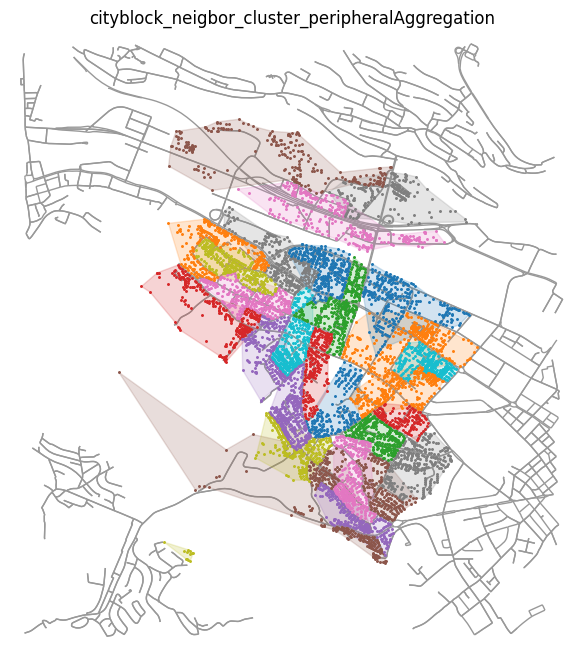

In [384]:
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_peripheralAggregation != "170"]
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_peripheralAggregation != "59"]
adresses_ = adresses_[adresses_.cityblock_neigbor_cluster_peripheralAggregation != "246"]
cluster_col = 'cityblock_neigbor_cluster_peripheralAggregation'

plot_cluster_shapes(adresses_,cluster_col)

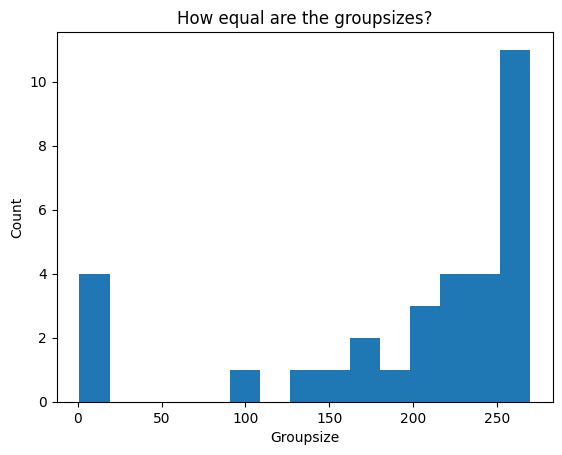

In [378]:
plt.hist(adresses['cityblock_neigbor_cluster_stepwise'].value_counts(), density=False, bins=15)
plt.title('How equal are the groupsizes?')
plt.ylabel('Count')
plt.xlabel('Groupsize');

In [ ]:
# df_ = gdf_cityblocks[['demo_regions','blocksize']].groupby(['demo_regions']).sum(['blocksize'])
# index_smalls = df_[df_.blocksize < 140].index.tolist()
# index_smalls


# gdf_cityblocks[gdf_cityblocks.label.isin(index_smalls)].plot(figsize=(7, 14), column="demo_regions", categorical=True, edgecolor="w").axis("off")

# Folium

In [1]:
#ox.folium.plot_graph_folium(G)